# Benchmarking of integration methods
In this notebook various integration methods will be evaluated with scib. Following this tutorial for large scale integration benchmarking: https://scib-metrics.readthedocs.io/en/stable/notebooks/large_scale.html //
This takes ~310 min in Jupyter Notebook and can crash, please look at the Python script that you can run as SLURM job. (Only use this to try out the functions/get a better understanding)

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import warnings
import matplotlib.cbook



/home/hers_basak/jjiang/jack/miniconda/envs/scarches/bin/python
3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
sys.version_info(major=3, minor=9, micro=18, releaselevel='final', serial=0)


Specific manual dependencies 
Numpy==1.23.5
r-base==

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import torch

os.environ['R_HOME'] = "/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/R/"

%matplotlib inline
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color

# This is used
# os.path.join('data/'+object_names[i][6:10]+'_preprocessed.h5ad')
#sc.logging.print_versions()

If you want to utilize GPU for NN

In [3]:
import faiss

from scib_metrics.nearest_neighbors import NeighborsOutput


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))

In [4]:
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

/scratch/7456293/ipykernel_941710/1004800601.py:1: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [5]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/')
sc.settings.figdir = '/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data//'
np.random.seed(41)

## Combining integrated latent representations in one h5ad file
skip if already done

In [ ]:
unintegrated_path='/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/'
scvi_path='/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_0/'
harmony_path='/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/harmony/'
scanorama_path='/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scanorama/'

unintegrated=f'{unintegrated_path}complete_base_hvg.h5ad'
scvi_n30=f'{scvi_path}adata_n30_scvi.h5ad'
harmony_n30=f'{harmony_path}adata_n30_harmony.h5ad'
scanorama_n30=f'{scanorama_path}adata_n30_scanorama.h5ad'

In [ ]:

files=[unintegrated,scvi_n30,harmony_n30,scanorama_n30]
names=['unintegrated','scvi_n30','harmony_n30','scanorama_n30']
object_names_merged=list()
numberobj = len(files)

for i in range(numberobj):
    object_names_merged.append("adata"+"_"+names[i])
    locals()[object_names_merged[i]] = sc.read(files[i]) 
    locals()[object_names_merged[i]].obs_names_make_unique()
    print(object_names_merged[i],' is loaded')

In [8]:
for i in range(numberobj):
    print(locals()[object_names_merged[i]])

AnnData object with n_obs × n_vars = 522220 × 4000
    obs: 'species', 'gender', 'age', 'instrument', 'technology', 'atlas', 'sample', 'batch_1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito', 'total_counts_norm', 'original_Library', 'original_Brain_Region', 'original_Level_1_cell_type', 'original_Level_2_cell_type', 'original_cellclass_lvl1', 'original_subclass_lvl3_1', 'original_cellclass_lvl1_n', 'original_lineage', 'original_subclass_lvl2', 'original_celltype_lvl3', 'donor', 'original_supercluster_term', 'original_cluster_id', 'original_subcluster_id', 'original_celltype', 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable

In [9]:
latents=['X_pca','X_scVI','X_pca_harmony','X_scanorama']
for i in range(numberobj):
    adata_scvi_n30.obsm[latents[i]] = locals()[object_names_merged[i]].obsm[latents[i]]

In [10]:
adata_scvi_n30.write('./complete_integrated_n30.h5ad')

## Load combined h5ad

In [6]:
adata_integrated = sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/adata_latent_2-4k.h5ad') 
print('adata_integrated is loaded')

adata_integrated is loaded


/home/hers_basak/jjiang/jack/miniconda/envs/scarches/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
labels=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_integration_l50/adata_labels.h5ad')

In [12]:
adata_integrated.obs['harmonized_cell_type_filtered_02_scvi'] = labels.obs['harmonized_cell_type_filtered_02_scvi']

In [21]:
adata_integrated=adata_integrated[pd.notna(adata_integrated.obs['harmonized_cell_type_filtered_02_scvi'])]

In [36]:
adata_integrated.write('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/adata_latent_2-4k.h5ad')

In [35]:
len(adata_integrated.obsm['X_scVI4k'].tolist())

507808

In [ ]:
import time

#310 min
adata_integrated.obsm["Unintegrated"] = adata_integrated.obsm["X_pca"]

biocons = BioConservation(isolated_labels=False,nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=True, silhouette_label=True, clisi_knn=True)
batchcor=BatchCorrection(silhouette_batch=True, ilisi_knn=True, kbet_per_label=True, graph_connectivity=True, pcr_comparison=True)
start = time.time()
bm = Benchmarker(
    adata_integrated,
    batch_key="atlas",
    label_key="harmonized_cell_type_filtered_02_scvi",
    embedding_obsm_keys=["Unintegrated", 'X_pca_harmony', 'X_scVI','X_scanorama'],
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=batchcor,
    n_jobs=-1,
)


In [ ]:
bm.prepare(neighbor_computer=faiss_brute_force_nn)


In [ ]:
bm.benchmark()
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

In [ ]:
bm.plot_results_table(min_max_scale=False,save_dir='/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/') 

In [ ]:
bm

In [ ]:
path='/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/'
bm.plot_results_table(show=False, save_dir=f'{path}scib_metrics/metrics.png')

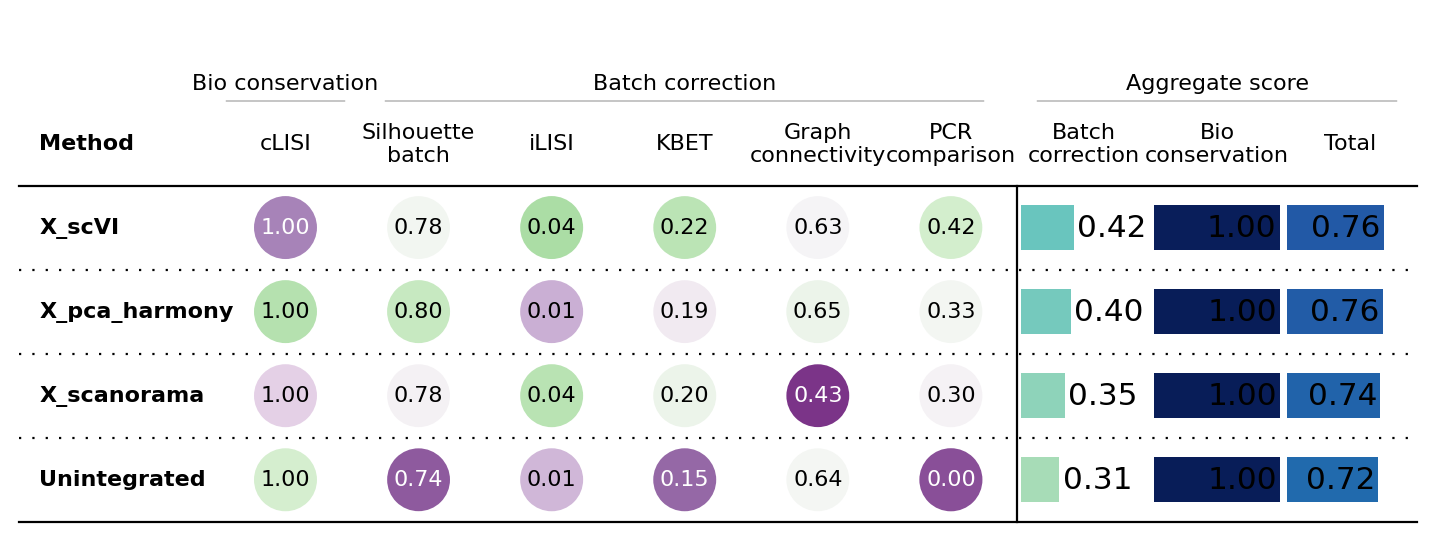

In [15]:
c

In [16]:
adata_integrated

AnnData object with n_obs × n_vars = 522220 × 4000
    obs: 'species', 'gender', 'age', 'instrument', 'technology', 'atlas', 'sample', 'batch_1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito', 'total_counts_norm', 'original_Library', 'original_Brain_Region', 'original_Level_1_cell_type', 'original_Level_2_cell_type', 'original_cellclass_lvl1', 'original_subclass_lvl3_1', 'original_cellclass_lvl1_n', 'original_lineage', 'original_subclass_lvl2', 'original_celltype_lvl3', 'donor', 'original_supercluster_term', 'original_cluster_id', 'original_subcluster_id', 'original_celltype', 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_varia

In [17]:
bm.get_results() 

,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,
Unintegrated,0.85168,0.0,0.047847,0.0,0.93018,0.0,0.195606,0.85168,0.58925
X_pca_harmony,1.0,1.0,0.0,0.579614,1.0,0.786391,0.673201,1.0,0.86928
X_scVI,0.0,0.749592,1.0,1.0,0.886876,1.0,0.927294,0.0,0.370918
X_scanorama,0.36171,0.668054,0.921658,0.744316,0.0,0.72449,0.611704,0.36171,0.461707
Metric Type,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [18]:
bm.get_results(False) 

,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,
Unintegrated,0.998336,0.735222,0.008615,0.152117,0.635966,0.0,0.306384,0.998336,0.721555
X_pca_harmony,0.99885,0.800139,0.006965,0.192617,0.651555,0.329001,0.396056,0.99885,0.757732
X_scVI,0.995381,0.783883,0.041437,0.22199,0.626297,0.418369,0.418395,0.995381,0.764587
X_scanorama,0.996636,0.77859,0.038737,0.204125,0.42828,0.303104,0.350567,0.996636,0.738208
Metric Type,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score
